In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.tree import export_text, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
)
import xgboost as xgb

# 00.EDA

In [2]:
PATH = "./dataproject2025.csv"
df = pd.read_csv(PATH).drop(columns=["Unnamed: 0"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   issue_d                  1086236 non-null  int64  
 1   loan duration            1086236 non-null  int64  
 2   annual_inc               1086236 non-null  float64
 3   avg_cur_bal              1086236 non-null  float64
 4   bc_open_to_buy           1086236 non-null  float64
 5   bc_util                  1086236 non-null  float64
 6   delinq_2yrs              1086236 non-null  float64
 7   dti                      1086236 non-null  float64
 8   emp_length               1086236 non-null  object 
 9   emp_title                1086236 non-null  object 
 10  fico_range_high          1086236 non-null  float64
 11  funded_amnt              1086236 non-null  float64
 12  grade                    1086236 non-null  object 
 13  home_ownership           1086236 non-null 

Certaines variables sont ordinales, on les retraite dans une fonction définie dans utils.py.

In [26]:
df.head()

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


Pour les subgrade, quel est l'ordre ? 

<Axes: xlabel='sub_grade'>

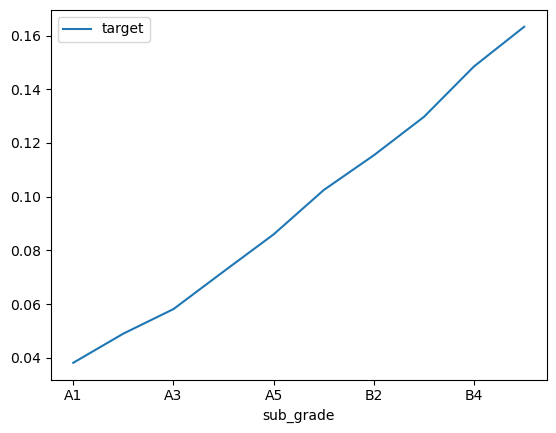

In [27]:
df[["sub_grade", "target"]].groupby("sub_grade").mean()[:10].plot()

Le jeu de données est relativement désequilibré mais les probabilités prédites ne sont pas trop heavy tailed

In [28]:
df["target"].value_counts()

target
0    857588
1    228648
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

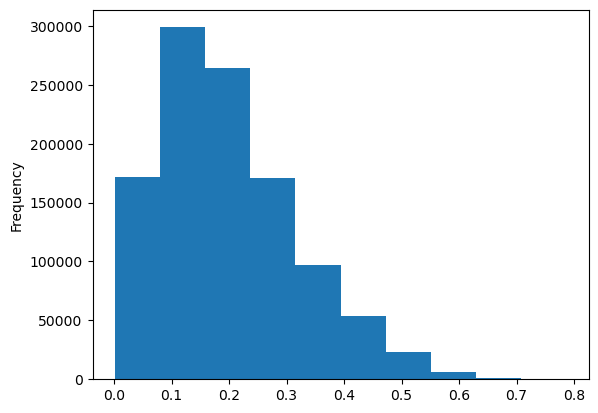

In [29]:
df["Predicted probabilities"].plot(kind="hist")

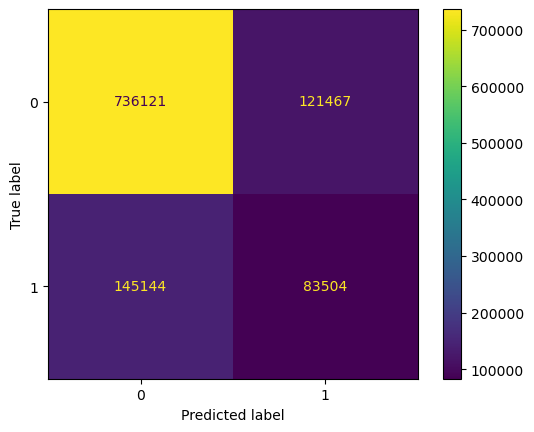

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df["target"], df["Predictions"])
disp = ConfusionMatrixDisplay(cm)
disp.plot();

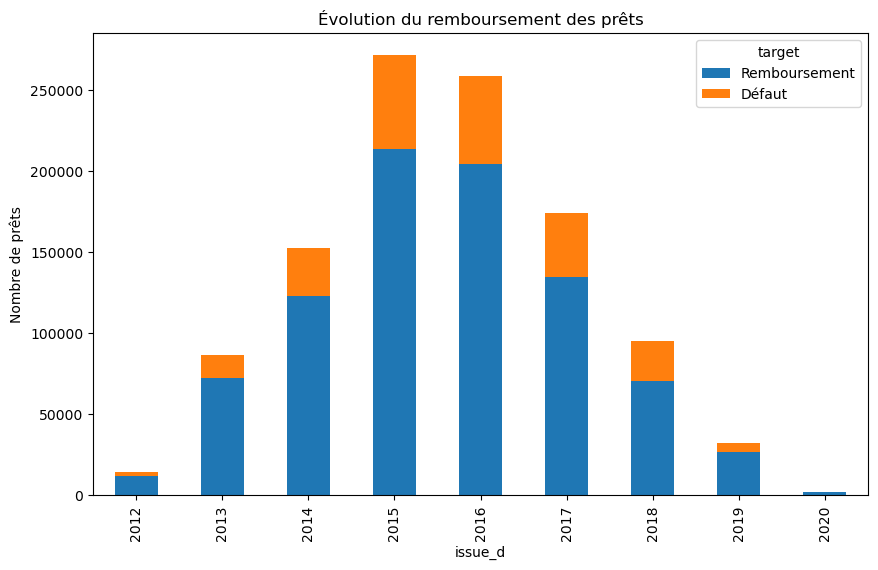

In [31]:
count_per_year = df.groupby(["issue_d", "target"])\
    .size()  \
    .unstack(fill_value=0)\
    .sort_index(ascending=True)

count_per_year = count_per_year.rename(columns={0: "Remboursement", 1: "Défaut"})

count_per_year[["Remboursement", "Défaut"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    ylabel="Nombre de prêts",
    title="Évolution du remboursement des prêts"
)

plt.show();

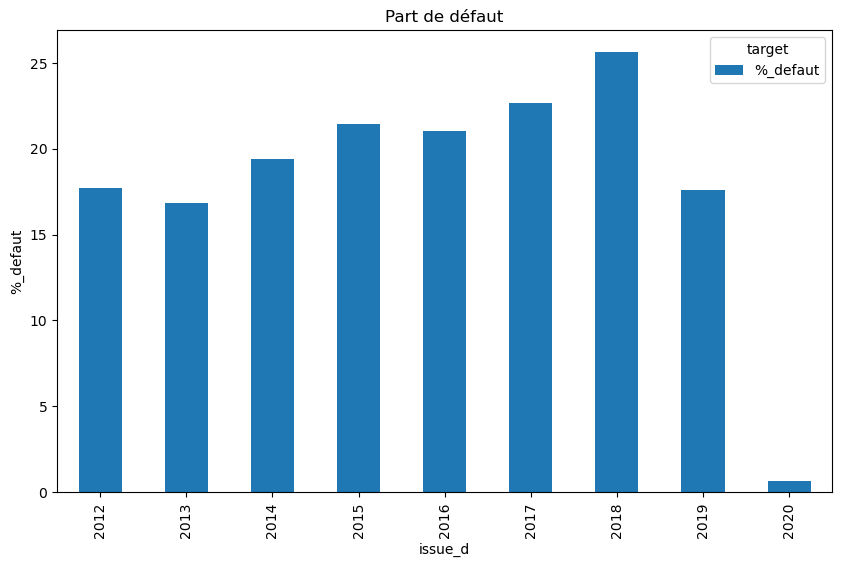

In [32]:
count_per_year["sum"] = count_per_year["Remboursement"] + count_per_year["Défaut"]
count_per_year["%_defaut"] = 100 * count_per_year["Défaut"] / count_per_year["sum"]

count_per_year[["%_defaut"]].plot(
    kind="bar",
    figsize=(10,6),
    ylabel="%_defaut",
    title="Part de défaut"
)
plt.show();

In [19]:
df.columns

Index(['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length',
       'emp_title', 'fico_range_high', 'funded_amnt', 'grade',
       'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target',
       'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions',
       'Predicted probabilities'],
      dtype='object')

Encodage binaire de la dure du prêt

In [21]:
df["loan duration"].unique()

array([0, 1])

<Axes: xlabel='annual_inc', ylabel='Predicted probabilities'>

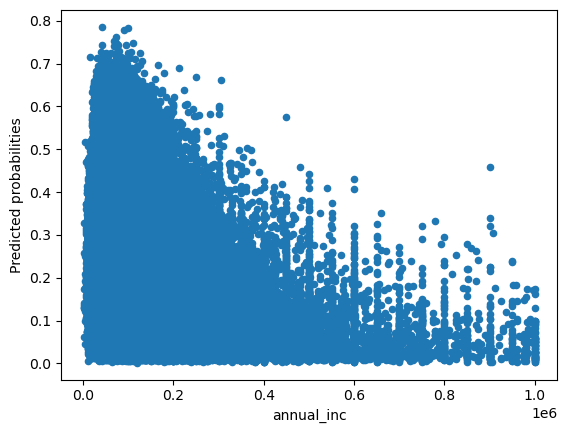

In [3]:
df.plot(kind="scatter",x="annual_inc", y="Predicted probabilities")

In [7]:
import plotly.express as px

fig = px.scatter_3d(
    df.sample(10_000), 
    x="funded_amnt", 
    y="int_rate", 
    z="Predicted probabilities",
    color="Predicted probabilities",  # dégradé de couleurs selon le risque
    opacity=0.7,
    size_max=5
)

fig.update_traces(marker=dict(size=3))  # taille des points
fig.write_html("scatter3d.html", auto_open=True)


Cutoff autour de 0.3

In [11]:
df[df["Predictions"] == 1]["Predicted probabilities"].describe()

count    204971.000000
mean          0.391725
std           0.072078
min           0.301355
25%           0.333034
50%           0.374926
75%           0.435205
max           0.785951
Name: Predicted probabilities, dtype: float64

In [22]:
df[df["Predictions"] == 0]["Predicted probabilities"].describe()

count    881265.000000
mean          0.153743
std           0.074126
min           0.001609
25%           0.093463
50%           0.150586
75%           0.212215
max           0.301354
Name: Predicted probabilities, dtype: float64

In [14]:
df[["Predicted probabilities", "emp_title"]].groupby("emp_title").mean().describe()

,Predicted probabilities
count,51.000000
mean,0.199250
std,0.042680
min,0.109690
25%,0.170750
50%,0.200735
75%,0.229331
max,0.295285


<Axes: title={'center': 'annual_inc'}, xlabel='emp_title'>

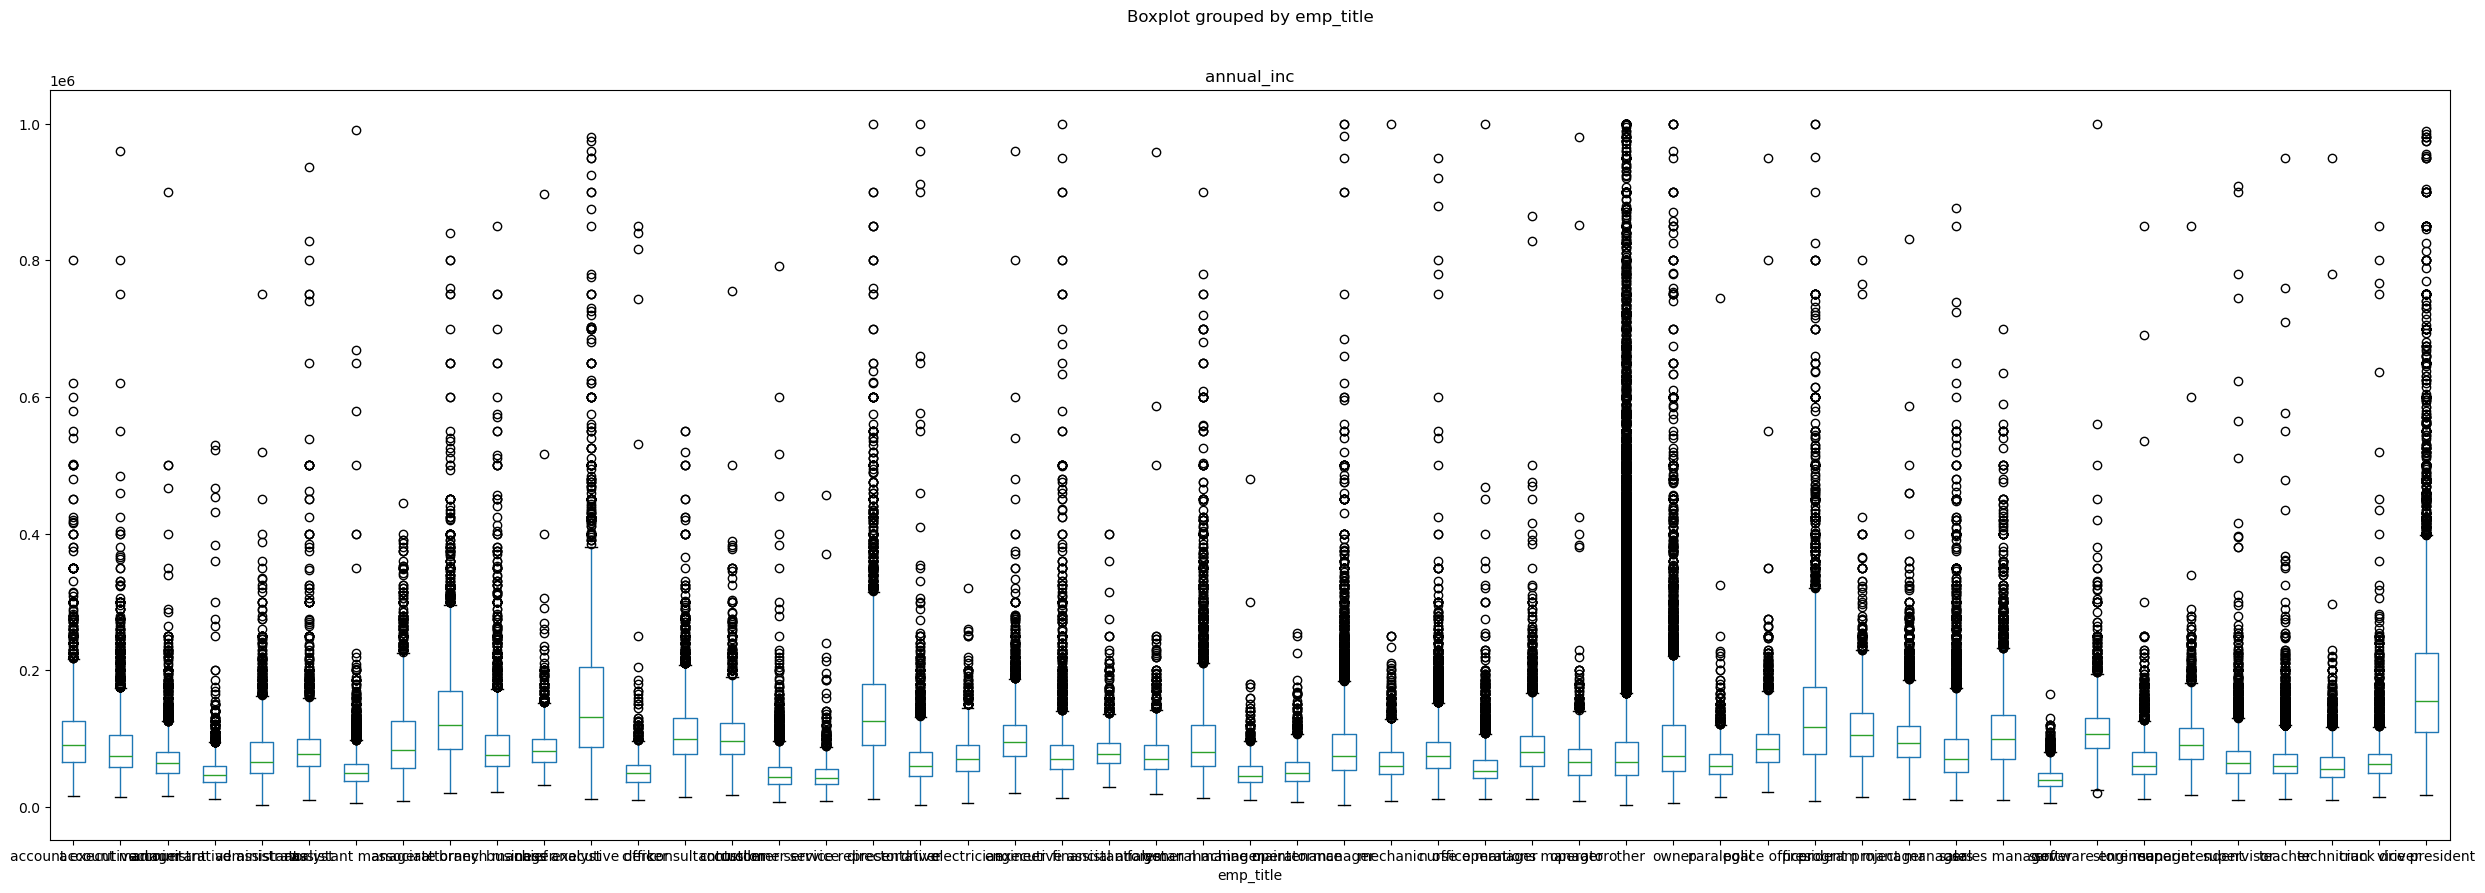

In [27]:
# Boxplot des revenus annuels par métier
df.boxplot(
    column="annual_inc",
    by="emp_title",
    grid=False,
    showfliers=True,   # True = montre les outliers
    vert=True,
    figsize=(30, 10)
)

# 01. First Surrogate : Linear Regression


On commence par une régression simple, sans encoding particulier. 

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skrub import TableVectorizer
from joblib import Memory

X = df.drop(columns=["Predicted probabilities", "Predictions", "target"])
y = df["Predicted probabilities"]


model = make_pipeline(
    TableVectorizer(numeric=StandardScaler(), n_jobs=1),
    LinearRegression(),
)

# equivalent to Kfold in this case but if we have more computer 
# could augment n_repeats
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

# poor computer, parallelizing sucks
cv_model = cross_validate(model, X, y, cv=cv,
                          return_estimator=True, n_jobs=1,
                          verbose=1)


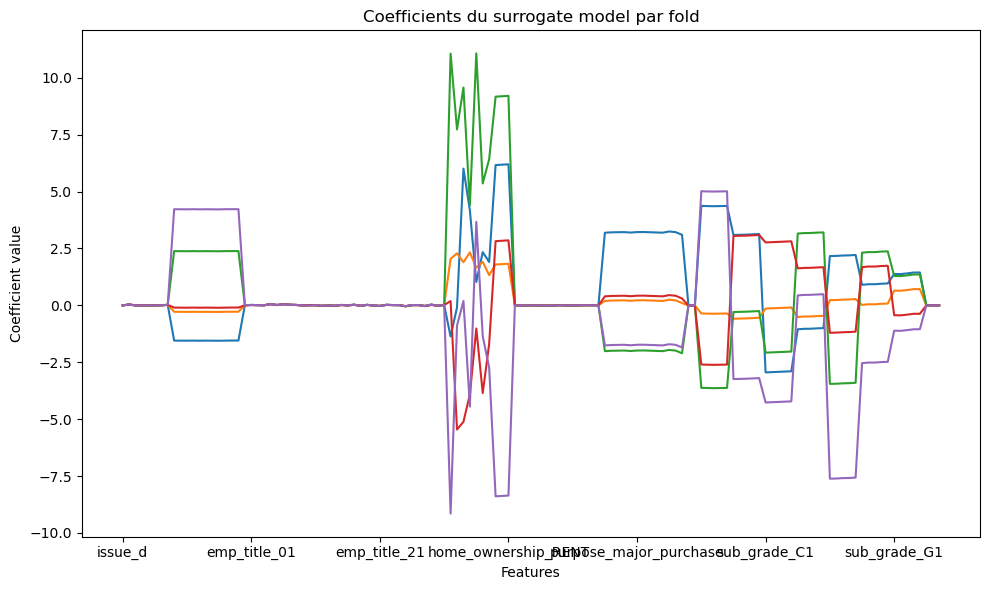

In [ ]:
feature_names = cv_model["estimator"][1][0].get_feature_names_out()

coefs = pd.DataFrame(
    [
        cv_model["estimator"][i][-1].coef_ for i in range(len(cv_model["estimator"]))
    ],
    columns=feature_names,
)
coefs.T.plot(legend=False, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show();

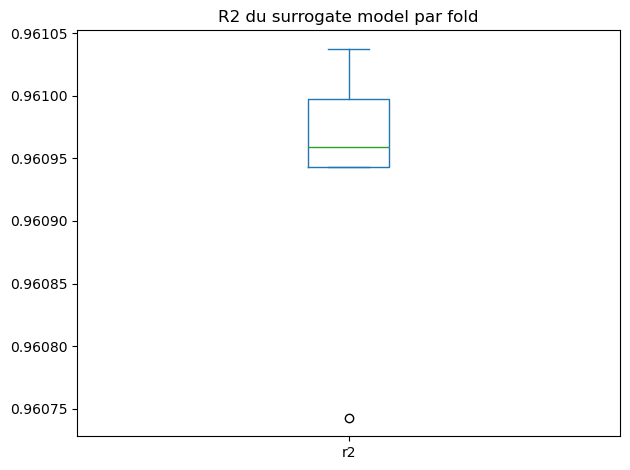

In [11]:
results = pd.DataFrame(cv_model["test_score"], columns=["r2"])
results.plot(kind="box", legend=False)
plt.title("R2 du surrogate model par fold")
plt.tight_layout()
plt.show();

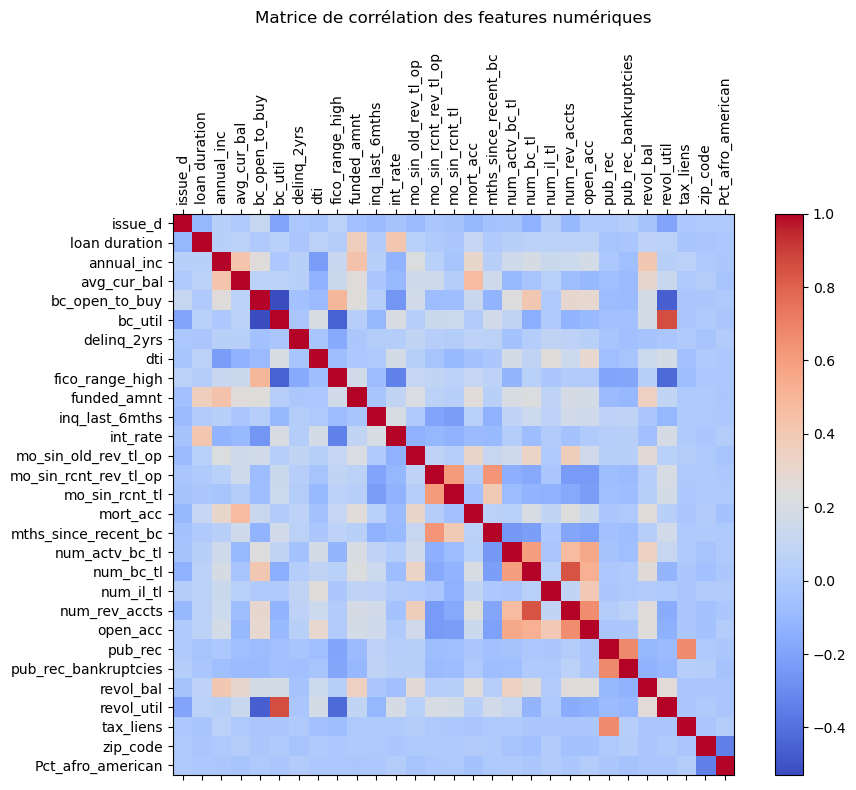

In [16]:
# keep only numeric columns
X_num = X.select_dtypes(include=["number"])

# correlation matrix
corr = X_num.corr()

# increase figsize
fig, ax = plt.subplots(figsize=(10, 8))  # width=10, height=8

cax = ax.matshow(corr, cmap="coolwarm")  # added a colormap for clarity
fig.colorbar(cax)

# add title
ax.set_title("Matrice de corrélation des features numériques", pad=20)

# add ticks with column names
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.tight_layout()
plt.show()

VIF

# 02. Time series split 

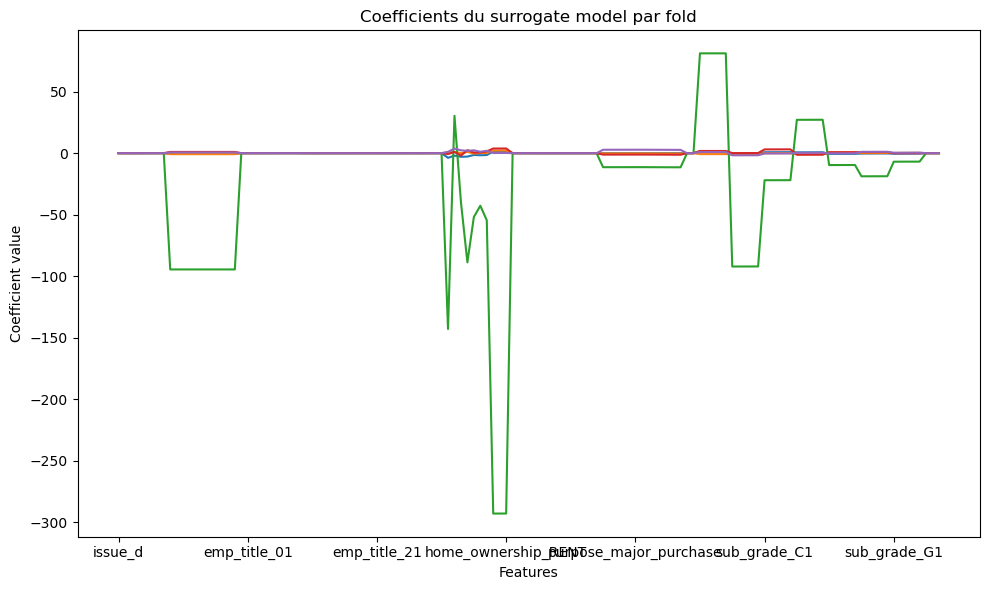

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skrub import TableVectorizer
from joblib import Memory


X = df.drop(columns=["Predicted probabilities", "Predictions", "target"])
y = df["Predicted probabilities"]


model = make_pipeline(
    TableVectorizer(numeric=StandardScaler(), n_jobs=1),
    LinearRegression(),
)

# equivalent to Kfold in this case but if we have more computer 
# could augment n_repeats
tscv = TimeSeriesSplit(n_splits=5)

# poor computer, parallelizing sucks
tscv_model = cross_validate(model, X, y, cv=tscv,
                          return_estimator=True, n_jobs=1,
                          verbose=1)

feature_names = tscv_model["estimator"][1][0].get_feature_names_out()

coefs = pd.DataFrame(
    [
        tscv_model["estimator"][i][-1].coef_ for i in range(len(tscv_model["estimator"]))
    ],
    columns=feature_names,
)


Visiblement le split 2 est hors compéitionn, on va le supprimer

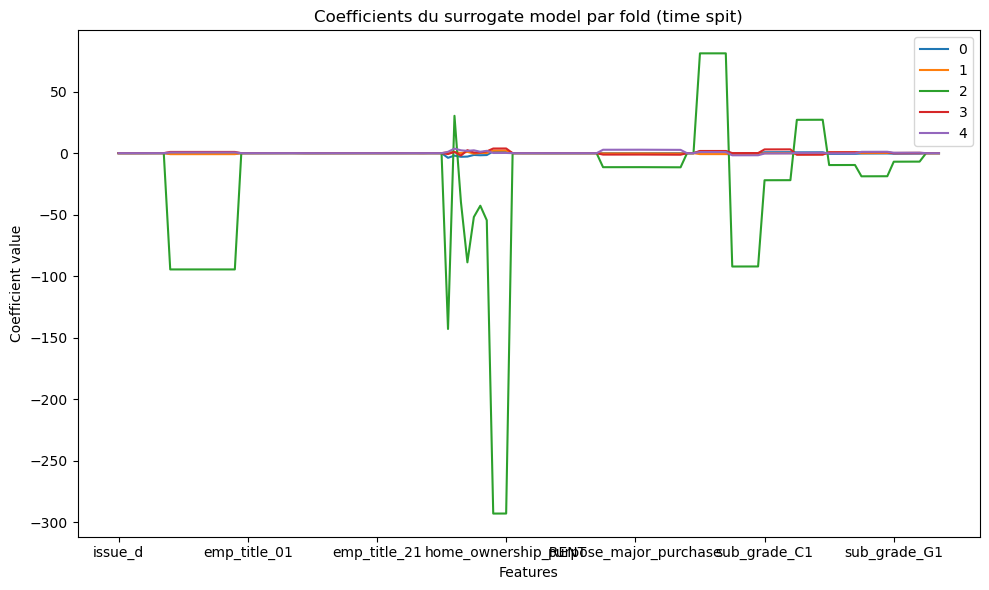

In [ ]:
coefs.T.plot(legend=True, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold (time spit)")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show();

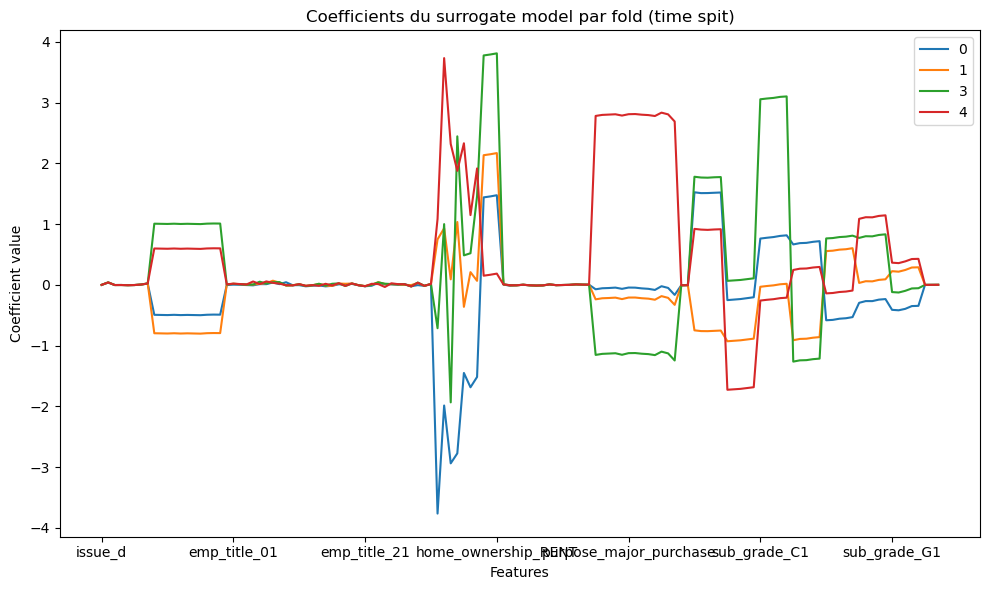

In [42]:
coefs.iloc[[0,1, 3, 4], :].T.plot(legend=True, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold (time spit)")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show();

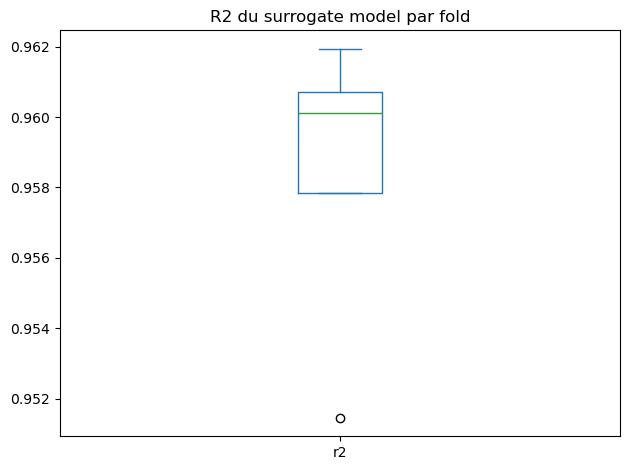

In [43]:
results = pd.DataFrame(tscv_model["test_score"], columns=["r2"])
results.plot(kind="box", legend=False)
plt.title("R2 du surrogate model par fold")
plt.tight_layout()
plt.show();

# 03. Proper encoding

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from skrub import TableVectorizer
from joblib import Memory
from utils import ordinal_encode

X = df.drop(columns=["Predicted probabilities", "Predictions", "target"])
X_encoded = ordinal_encode(X).sort_values(by="issue_d", ascending=True)
y = df["Predicted probabilities"]

model = make_pipeline(
    # 51 emp_title différents, si on précise rien, embeddé par gapencoder
    TableVectorizer(numeric=StandardScaler(), n_jobs=1, cardinality_threshold=52),
    LinearRegression(),
)

# equivalent to Kfold in this case but if we have more computer 
# could augment n_repeats
tscv = TimeSeriesSplit(n_splits=5)

# poor computer, parallelizing sucks
encoded_model = cross_validate(model, X_encoded, y, cv=tscv,
                          return_estimator=True, n_jobs=1,
                          verbose=1)


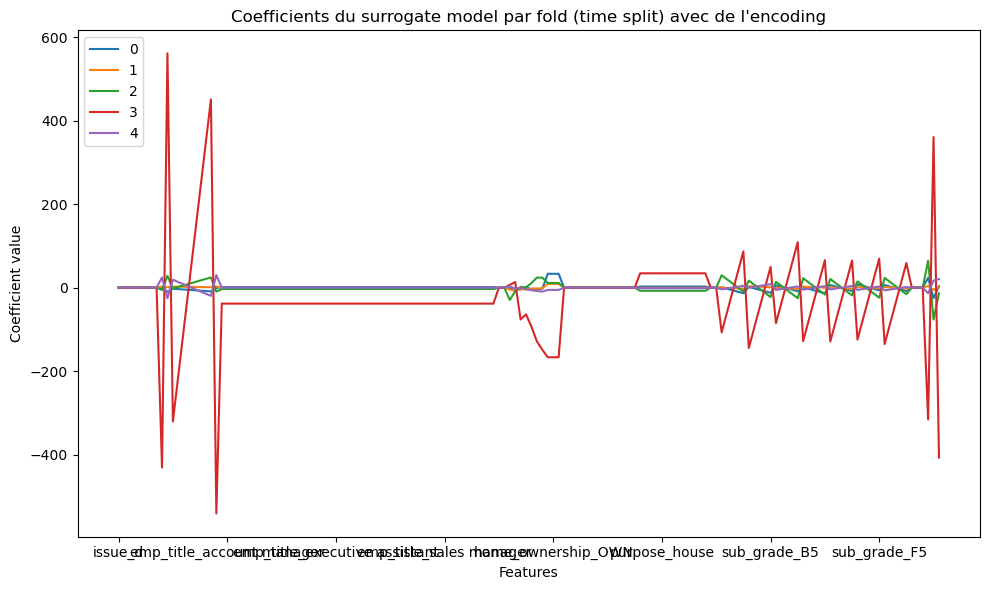

In [19]:
feature_names = encoded_model["estimator"][2][0].get_feature_names_out()

coefs = pd.DataFrame(
    [
        encoded_model["estimator"][i][-1].coef_ for i in range(len(encoded_model["estimator"]))
    ],
    columns=feature_names,
)

coefs.T.plot(legend=True, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold (time split) avec de l'encoding")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show();

In [36]:
coefs.T[4].describe()

count    152.000000
mean      -0.040590
std        0.158210
min       -0.696646
25%       -0.080195
50%       -0.018395
75%        0.014939
max        0.696800
Name: 4, dtype: float64

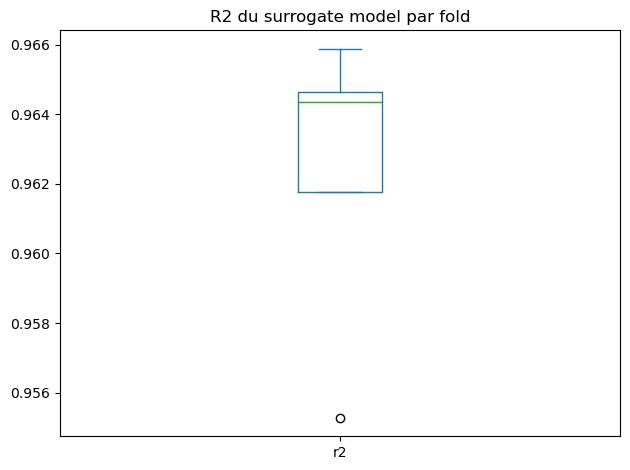

In [10]:
pd.DataFrame(encoded_model["test_score"], columns=["r2"]).plot(kind="box", legend=False)
plt.title("R2 du surrogate model par fold")
plt.tight_layout()
plt.show();

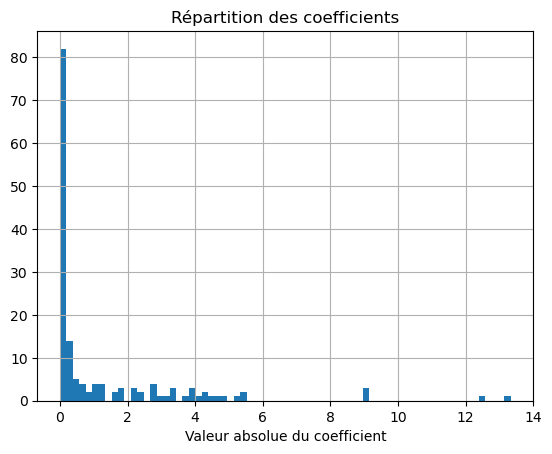

In [11]:
df_coef = coefs.T
df_coef["abs_mean"] = df_coef.apply(lambda x :np.abs(np.mean(x)), axis=1)
df_coef["abs_mean"].hist(bins=70)
plt.xlabel("Valeur absolue du coefficient")
plt.title("Répartition des coefficients");

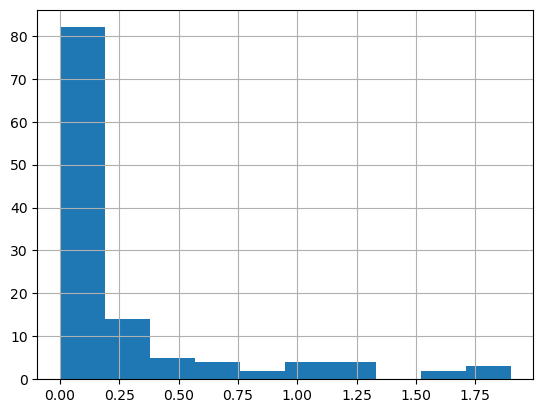

In [12]:
df_coef[df_coef["abs_mean"] < 2]["abs_mean"].hist();

In [18]:
df_coef.T["annual_inc"]

0          -0.003388
1          -0.003036
2          -0.002950
3          -0.003029
4          -0.003214
abs_mean    0.003123
Name: annual_inc, dtype: float32

In [16]:
df_coef[df_coef["abs_mean"] > 8].index

Index(['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'subgrade_encoded', 'grade_encoded'],
      dtype='object')

In [14]:
(df_coef["abs_mean"] < 1).sort_values(ascending=True).index.to_list()

['grade_D',
 'sub_grade_C1',
 'sub_grade_B5',
 'sub_grade_B3',
 'sub_grade_B2',
 'sub_grade_B1',
 'sub_grade_A5',
 'sub_grade_A4',
 'sub_grade_A2',
 'sub_grade_A1',
 'home_ownership_RENT',
 'home_ownership_OWN',
 'home_ownership_MORTGAGE',
 'grade_G',
 'grade_F',
 'grade_E',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'subgrade_encoded',
 'sub_grade_G5',
 'sub_grade_G4',
 'sub_grade_G2',
 'sub_grade_G1',
 'sub_grade_F5',
 'sub_grade_F4',
 'grade_encoded',
 'sub_grade_F2',
 'sub_grade_E5',
 'sub_grade_E3',
 'sub_grade_E2',
 'sub_grade_E1',
 'sub_grade_D5',
 'sub_grade_D4',
 'sub_grade_D2',
 'sub_grade_F1',
 'grade_B',
 'emp_length_encoded',
 'emp_length_< 1 year',
 'emp_length_4 years',
 'emp_length_3 years',
 'emp_length_1 year',
 'emp_length_2 years',
 'emp_title_engineer',
 'emp_title_administrator',
 'emp_title_analyst',
 'emp_title_assistant manager',
 'emp_title_associate',
 'emp_title_attorney',
 'sub_grade_A3',
 'emp_title_branch manager',
 'emp_title_bu

Est ce qu'il ya une variabilité selon le type d'emploi ? Pas tellemetn, à mon avis redondant e t pert en interprétabilité

In [29]:
df.groupby("emp_title")[["Predicted probabilities", "annual_inc"]].mean().corr()

,Predicted probabilities,annual_inc
Predicted probabilities,1.000000,-0.615363
annual_inc,-0.615363,1.000000


Visiblement le mixed effect de l'ordinal encoding ne sert à rien 

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from skrub import TableVectorizer
from joblib import Memory
from utils import ordinal_encode

X = df.drop(columns=["Predicted probabilities", "Predictions", "target"])
X_encoded = ordinal_encode(X, drop=True).drop(columns=['emp_title']).sort_values(by="issue_d")
y = df["Predicted probabilities"]

model = make_pipeline(
    # 51 emp_title différents, si on précise rien, embeddé par gapencoder
    TableVectorizer(numeric=StandardScaler(), n_jobs=1, cardinality_threshold=52),
    LinearRegression(),
)

# equivalent to Kfold in this case but if we have more computer 
# could augment n_repeats
tscv = TimeSeriesSplit(n_splits=5)

# poor computer, parallelizing sucks
encoded_model = cross_validate(model, X_encoded, y, cv=tscv,
                          return_estimator=True, n_jobs=1,
                          verbose=1)


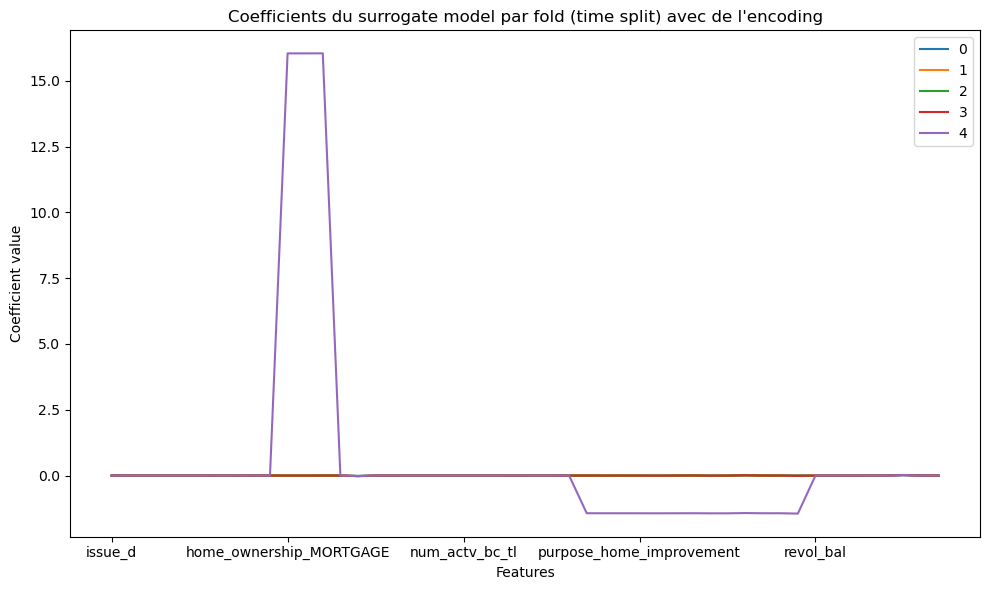

In [17]:
feature_names = encoded_model["estimator"][2][0].get_feature_names_out()

coefs = pd.DataFrame(
    [
        encoded_model["estimator"][i][-1].coef_ for i in range(len(encoded_model["estimator"]))
    ],
    columns=feature_names,
)

coefs.T.plot(legend=True, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold (time split) avec de l'encoding")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show();

In [11]:
coefs.std(axis=1)

0    0.025223
1    0.024014
2    0.023527
3    1.648774
4    0.022209
dtype: float32

In [12]:
coefs.mean(axis=1)

0    0.001617
1    0.001686
2    0.001762
3   -0.156954
4    0.001751
dtype: float32

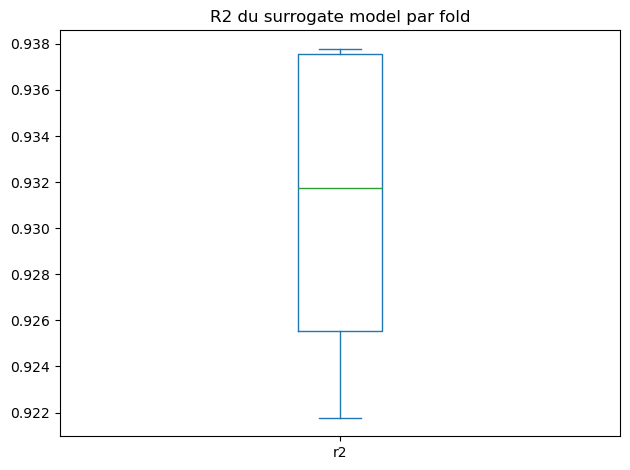

In [13]:
pd.DataFrame(encoded_model["test_score"], columns=["r2"]).plot(kind="box", legend=False)
plt.title("R2 du surrogate model par fold")
plt.tight_layout()
plt.show();

In [15]:
encoded_model

{'fit_time': array([ 2.63724399,  5.3383007 ,  8.74693775, 14.32159591, 18.28517699]),
 'score_time': array([1.54988766, 1.58305264, 1.50747395, 1.62042165, 1.75623465]),
 'estimator': [Pipeline(steps=[('tablevectorizer',
                   TableVectorizer(cardinality_threshold=52, n_jobs=1,
                                   numeric=StandardScaler())),
                  ('linearregression', LinearRegression())]),
  Pipeline(steps=[('tablevectorizer',
                   TableVectorizer(cardinality_threshold=52, n_jobs=1,
                                   numeric=StandardScaler())),
                  ('linearregression', LinearRegression())]),
  Pipeline(steps=[('tablevectorizer',
                   TableVectorizer(cardinality_threshold=52, n_jobs=1,
                                   numeric=StandardScaler())),
                  ('linearregression', LinearRegression())]),
  Pipeline(steps=[('tablevectorizer',
                   TableVectorizer(cardinality_threshold=52, n_jobs=1,
     

In [ ]:
X_test